In [54]:
import tensorflow as tf
import numpy as np
import scipy
from tensorflow import keras

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [55]:
#Initialisations (constants throughout project)

BATCH_SIZE=32
IMAGE_SIZE=HEIGHT=WIDTH=256
CHANNEL_SIZE=3
INPUT_SHAPE=(BATCH_SIZE,HEIGHT,WIDTH,CHANNEL_SIZE)
DS_FOLDER=r"C:\Users\vyoge\code\learning-ml\learning-ml\project-indian-medicinal-leaf-and-plants-classification\datasets\indian-medicinal-leaves-image-datasets\Medicinal Leaf dataset"

## Load the dataset

In [56]:
ds=keras.preprocessing.image_dataset_from_directory(directory=DS_FOLDER,
                                                    batch_size=BATCH_SIZE,
                                                    color_mode="rgb",
                                                    crop_to_aspect_ratio=True,image_size=(HEIGHT,WIDTH),
                                                    interpolation="bilinear")

Found 6900 files belonging to 80 classes.


In [57]:
ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

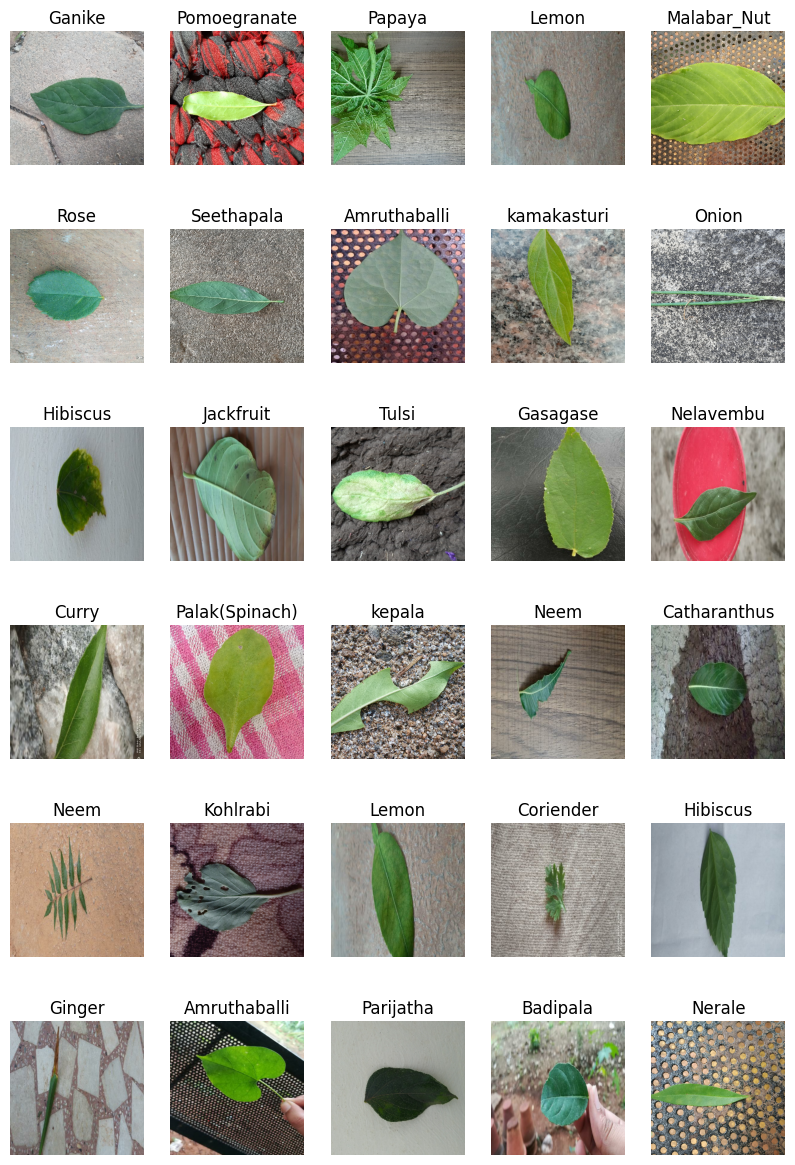

In [58]:
plt.figure(figsize=(10,15))
# Exploring the dataset
for image_batch,label_batch in ds.take(1):
    for i in range(30):
        plt.subplot(6,5,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint'))
        plt.title(ds.class_names[label_batch[i]])
        plt.axis(False)
        

## Create train,test,split

In [59]:
def make_train_valid_test_split(ds,train_split=.8,test_split=.2):
    if train_split+test_split>1.:
        raise Exception("train+test cannot be greater than 1.")
        
    n_total_batches=len(ds)
    n_train_batches=int(n_total_batches*train_split)
    n_test_batches =int(n_total_batches*test_split)
    n_valid_batches=n_total_batches-n_train_batches-n_test_batches
    
    train_ds=ds.take(n_train_batches)
    test_ds=ds.skip(n_train_batches).take(n_test_batches)
    valid_ds=ds.skip(n_train_batches+n_test_batches).take(n_valid_batches)
    
    
    print(f"{n_total_batches}- Total no of batches will be split to- ")
    
    print(f"{len(train_ds)}- no of training batches")
    print(f"{len(test_ds)}- no of test batches")
    print(f"{len(valid_ds)}- no of valid batches")
        
    
    return train_ds,valid_ds,test_ds

In [60]:
train_ds,test_ds,valid_ds=make_train_valid_test_split(ds)

216- Total no of batches will be split to- 
172- no of training batches
43- no of test batches
1- no of valid batches


## Improve dataset for training- set up Data augmentation on the flow


In [61]:
datagen=keras.preprocessing.image.ImageDataGenerator(shear_range=.1,
                                                     brightness_range=(.6,1.4),
                                                     fill_mode="wrap",
                                                     horizontal_flip=True,
                                                     rotation_range=20,
                                                     zoom_range=.2)

In [62]:
datagen

In [63]:
'''
datagen.fit(x=train_ds)
# log- apparently only when you have training set in the form of numpy array you need to fit???
# log- if using datagen.flow() to generate on the flow, you dont have to fit?
'''

'\ndatagen.fit(x=train_ds)\n# log- apparently only when you have training set in the form of numpy array you need to fit???\n# log- if using datagen.flow() to generate on the flow, you dont have to fit?\n'

In [64]:
for image_batch,label_batch in train_ds.take(3):
    a=datagen.fit(image_batch)

In [65]:
# LEts Try datagen once before applying...
for image_batch,label_batch in train_ds.take(1):
    i=0
    for _ in datagen.flow(save_to_dir="temp_augmentation_test",
                          save_format=".jpg",
                          batch_size=10,
                          x=image_batch):
        i+=1
        if i>5:
            break


## Building model 


In [66]:
# PREprocessing Layers:

layer_resize_and_rescale=keras.Sequential(name="layer_resize_and_rescale",
                                          layers=[keras.layers.experimental.preprocessing.Rescaling(1./255),
                                                  keras.layers.experimental.preprocessing.Resizing(width=WIDTH,height=HEIGHT)])


## Build preprocessing layers


In [67]:
# cluster all preprocessing layers together
all_preprocessing_layers=keras.Sequential(name="all_preprocessing_layers",
                                          layers=[layer_resize_and_rescale])
all_preprocessing_layers.build(INPUT_SHAPE)
all_preprocessing_layers.summary()

Model: "all_preprocessing_layers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_resize_and_rescale (S  (32, 256, 256, 3)        0         
 equential)                                                      
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [68]:
# BUILDING the learning_layers

In [69]:
model=keras.Sequential(name="cnn_layers",
                                 layers=[layer_resize_and_rescale,
                                         keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation="relu"),
                                         keras.layers.MaxPooling2D(pool_size=(2,2)),
                                         keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation="relu"),
                                         keras.layers.MaxPooling2D(pool_size=(2,2)),                                         
                                         keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation="relu"),
                                         keras.layers.MaxPooling2D(pool_size=(4,4)),
                                         keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation="relu"),
                                         keras.layers.MaxPooling2D(pool_size=(4,4)),
                                         keras.layers.Flatten(),
                                         keras.layers.Dense(units=150,activation="relu"),
                                         keras.layers.Dense(units=len(ds.class_names),activation="softmax")
                                        ])

## Build CNN layers
## Build Final layers and Finalise Model


In [70]:
model.build(INPUT_SHAPE)
model.summary()


Model: "cnn_layers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_resize_and_rescale (S  (32, 256, 256, 3)        0         
 equential)                                                      
                                                                 
 conv2d_4 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (32, 125, 125, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (32, 62, 62, 32)         0         
 2D)                                                             
                                                        

In [71]:
model.compile(optimizer='adam', 
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])



## Compile and train the model

In [73]:
'''
def train_data_generator():
    for image_batch,label_batch in train_ds.take(1):
        yield image_batch,label_batch

def valid_data_generator():
    for image_batch,label_batch in valid_ds.take(1):
        yield image_batch

'''


'\ndef train_data_generator():\n    for image_batch,label_batch in train_ds.take(1):\n        yield image_batch,label_batch\n\ndef valid_data_generator():\n    for image_batch,label_batch in valid_ds.take(1):\n        yield image_batch\n\n'

In [74]:
#x,y=next(datagen.flow(train_data_generator()))
'''
history=model.fit(next(train_data_generator()), validation_data=valid_ds, epochs=2)
'''


'\nhistory=model.fit(next(train_data_generator()), validation_data=valid_ds, epochs=2)\n'

In [21]:
tf.data.Dataset

tensorflow.python.data.ops.dataset_ops.DatasetV2

In [26]:
for image_batch,label_batch in train_ds.take(1):
    print(label_batch)
    
    break

tf.Tensor(
[34 25 14 20 24 21 72 10 47 68 61 31 37  0 49  3 65 28 56 52 22 21  0 68
 53 48  4  9 45 36  9  3 53 11 18 65 41 62  2  9 69 50 22 19 61 27 32 68
 72 38 33 22 49 28 13 34 29 18 14 64 52 78 52 66], shape=(64,), dtype=int32)


In [29]:
for a,b in train_ds.take(1):
    print (a)
    print (type(a))
    print (b)
    print (type(b))

tf.Tensor(
[[[[155.61424   156.61424   148.61424  ]
   [154.36821   155.36821   147.36821  ]
   [151.27344   151.3789    143.3789   ]
   ...
   [114.66106   109.66106   105.66106  ]
   [113.60054   108.60054   104.60054  ]
   [113.24219   110.24219   105.24219  ]]

  [[156.51562   157.51562   149.51562  ]
   [154.58984   155.58984   147.58984  ]
   [151.90895   152.01442   144.01442  ]
   ...
   [113.08864   108.08864   104.08864  ]
   [114.254745  109.254745  105.254745 ]
   [110.39946   107.39946   102.39946  ]]

  [[158.82903   159.27344   151.27344  ]
   [157.11989   157.22536   149.22536  ]
   [152.09435   152.10547   144.10547  ]
   ...
   [112.22206   107.22206   103.22206  ]
   [114.8777    109.8777    105.8777   ]
   [107.766525  104.766525   99.766525 ]]

  ...

  [[175.24219   170.24219   164.24219  ]
   [172.72656   167.72656   161.72656  ]
   [171.        166.        160.       ]
   ...
   [115.        110.        106.       ]
   [118.453125  113.453125  109.453125 ]
   [1

In [30]:
for i in train_ds.take(1):
    return datagen.flow(i)



In [75]:
def train_data_generator():
    for i in train_ds.take(1):
        yield datagen.flow(i)

def valid_data_generator():
    for j in valid_ds.take(1):
        yield datagen.flow(j)


In [33]:
a=next(train_data_generator())
type(a)

keras.preprocessing.image.NumpyArrayIterator

In [39]:
for i in a:
    print(type(i)) 

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'li

KeyboardInterrupt: 

In [40]:
len(a)

2

In [48]:
for i in a:
    print(len(i))
    
    print(i[1])
        
    break


2
[18 68 66 62 18 26 67 18  0 31 24 18 21 29 17 20 68 35 49 12  7 72 57  0
 21  3 49  7 76 41 14 19]


In [44]:
j.shape

(32, 256, 256, 3)

In [50]:
j.shape

(32, 256, 256, 3)

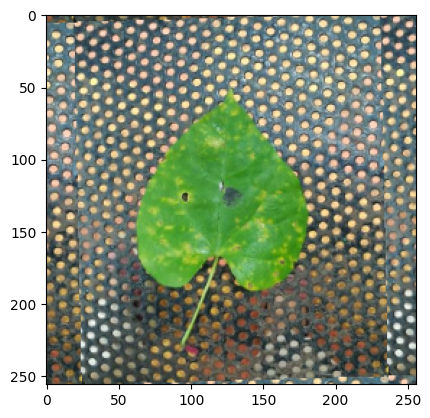

In [53]:
plt.imshow(j[0].astype('uint'))

In [76]:
history=model.fit(next(train_data_generator()),validation_data=next(valid_data_generator()),epochs=1)

1/1 [==============================] - 3s 3s/step - loss: 4.3848 - accuracy: 0.0000e+00 - val_loss: 4.3799 - val_accuracy: 0.0312


## Model Evaluation (plotting history of training)

## Real time prediction of leaves (with pictures plotted)